In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import hdbscan
import psycopg2 
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

# For offline use
cf.go_offline()

%matplotlib inline

from IPython.display import HTML

In [2]:
import datapackage
import pandas as pd

data_url = 'https://datahub.io/core/gold-prices/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        data = pd.read_csv(resource.descriptor['path'])
        print (data)

       Date     Price
0   1950-12    34.720
1   1951-12    34.660
2   1952-12    34.790
3   1953-12    34.850
4   1954-12    35.040
..      ...       ...
65  2015-12  1068.317
66  2016-12  1152.165
67  2017-12  1265.674
68  2018-12  1249.887
69  2019-12  1480.025

[70 rows x 2 columns]
        Date     Price
0    1950-01    34.730
1    1950-02    34.730
2    1950-03    34.730
3    1950-04    34.730
4    1950-05    34.730
..       ...       ...
842  2020-03  1593.764
843  2020-04  1680.030
844  2020-05  1715.697
845  2020-06  1734.032
846  2020-07  1840.807

[847 rows x 2 columns]
Empty DataFrame
Columns: [[{"Date": "1950-12",  "Price": 34.72}, {"Date": "1951-12",  "Price": 34.66}, {"Date": "1952-12",  "Price": 34.79}, {"Date": "1953-12",  "Price": 34.85}, {"Date": "1954-12",  "Price": 35.04}, {"Date": "1955-12",  "Price": 34.97}, {"Date": "1956-12",  "Price": 34.9}, {"Date": "1957-12",  "Price": 34.99}, {"Date": "1958-12",  "Price": 35.09}, {"Date": "1959-12",  "Price": 35.05}, {"Date"

In [3]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
data['Date'] = data[['Date']].apply(pd.to_datetime)

In [5]:
#data['Month'] = pd.DatetimeIndex(data['Date']).month

In [6]:
#data['Year'] = pd.DatetimeIndex(data['Date']).year

In [7]:
data.set_index('Date',inplace=True)

In [8]:
data.head()

,Price
Date,
1950-01-01,34.73
1950-02-01,34.73
1950-03-01,34.73
1950-04-01,34.73
1950-05-01,34.73


In [9]:
data.drop(data.index[:240], inplace=True)

In [10]:
data

,Price
Date,
1970-01-01,34.946
1970-02-01,34.994
1970-03-01,35.089
1970-04-01,35.623
1970-05-01,35.958
...,...
2020-03-01,1593.764
2020-04-01,1680.030
2020-05-01,1715.697


<AxesSubplot:xlabel='Date', ylabel='Price'>

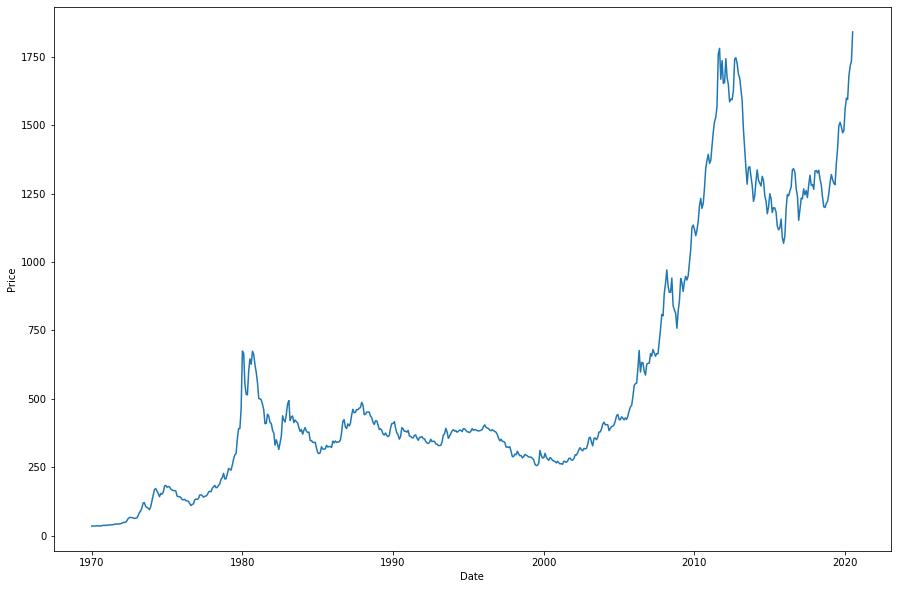

In [11]:
plt.figure(figsize=(15,10))
sns.lineplot(x = 'Date',y='Price',data=data)

In [12]:
len(data)

607

In [13]:
len(data)- 60

547

In [14]:
test_size = 60

In [15]:
test_ind = len(data)- test_size

In [16]:
train = data.iloc[:test_ind]
test = data.iloc[test_ind:]

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [23]:
# What does the first batch look like?
X,y = generator[0]

In [24]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00000000e+00 2.74961019e-05 8.19154701e-05 3.87809603e-04
 5.79709481e-04 2.81262209e-04 2.19395979e-04 2.46892081e-04
 7.16044319e-04 1.49338203e-03 1.43724416e-03 1.42521461e-03]
Predict this y: 
 [[0.00167383]]


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
# We're only using one feature in our time series
n_features = 1

In [27]:
# define model
model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [31]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [32]:
# fit model
model.fit_generator(generator,epochs=100,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
535/535 [==============================] - 4s 8ms/step - loss: 0.0711 - val_loss: 0.2942
Epoch 2/100
535/535 [==============================] - 4s 8ms/step - loss: 0.0518 - val_loss: 0.2517
Epoch 3/100
535/535 [==============================] - 7s 13ms/step - loss: 0.0514 - val_loss: 0.2626
Epoch 4/100
535/535 [==============================] - 7s 13ms/step - loss: 0.0514 - val_loss: 0.2473
Epoch 5/100
535/535 [==============================] - 6s 12ms/step - loss: 0.0513 - val_loss: 0.2578
Epoch 6/100
535/535 [==============================] - 7s 14ms/step - loss: 0.0514 - val_loss: 0.2633


In [33]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

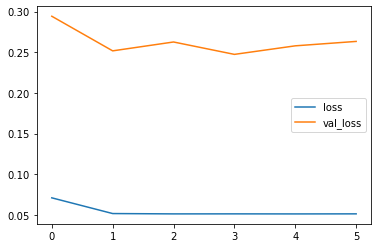

In [34]:
losses.plot()

In [35]:
first_eval_batch = scaled_train[-length:]

In [36]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [37]:
model.predict(first_eval_batch)

array([[0.25178277]], dtype=float32)

In [38]:
scaled_test[0]

array([0.62013963])

In [39]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [42]:
test

,Price,Predictions
Date,,
2015-08-01,1117.525,474.483694
2015-09-01,1124.905,474.483694
2015-10-01,1157.123,474.483694
2015-11-01,1088.388,474.483694
2015-12-01,1068.317,474.483694
2016-01-01,1095.655,474.483694
2016-02-01,1194.893,474.483694
2016-03-01,1246.312,474.483694
2016-04-01,1241.452,474.483694


<AxesSubplot:xlabel='Date'>

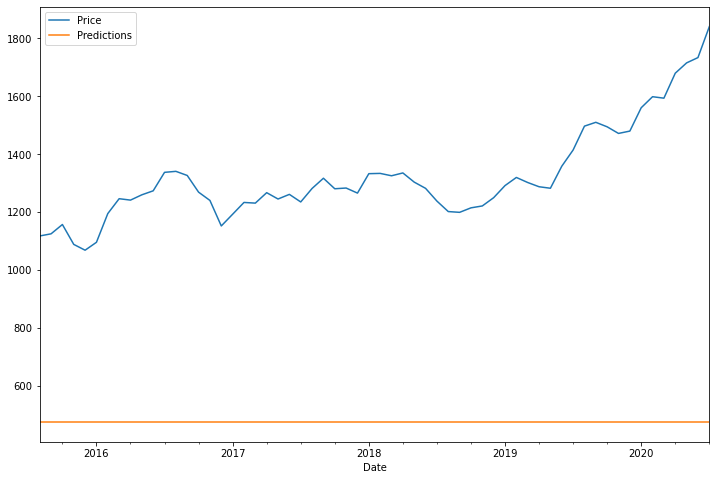

In [43]:
test.plot(figsize=(12,8))

In [44]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(data)

In [45]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [46]:
model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator,epochs=6)

Epoch 1/6
595/595 [==============================] - 5s 8ms/step - loss: 0.0035
Epoch 2/6
595/595 [==============================] - 5s 9ms/step - loss: 5.5028e-04
Epoch 3/6
595/595 [==============================] - 5s 9ms/step - loss: 4.5680e-04
Epoch 4/6
595/595 [==============================] - 4s 7ms/step - loss: 5.1755e-04
Epoch 5/6
595/595 [==============================] - 4s 7ms/step - loss: 4.8673e-04
Epoch 6/6
595/595 [==============================] - 4s 7ms/step - loss: 5.0854e-04


In [47]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [48]:
forecast = scaler.inverse_transform(forecast)

In [49]:
forecast_index = pd.date_range(start='2020-08-01',periods=periods,freq='MS')

In [50]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:xlabel='Date'>

<Figure size 1080x720 with 0 Axes>

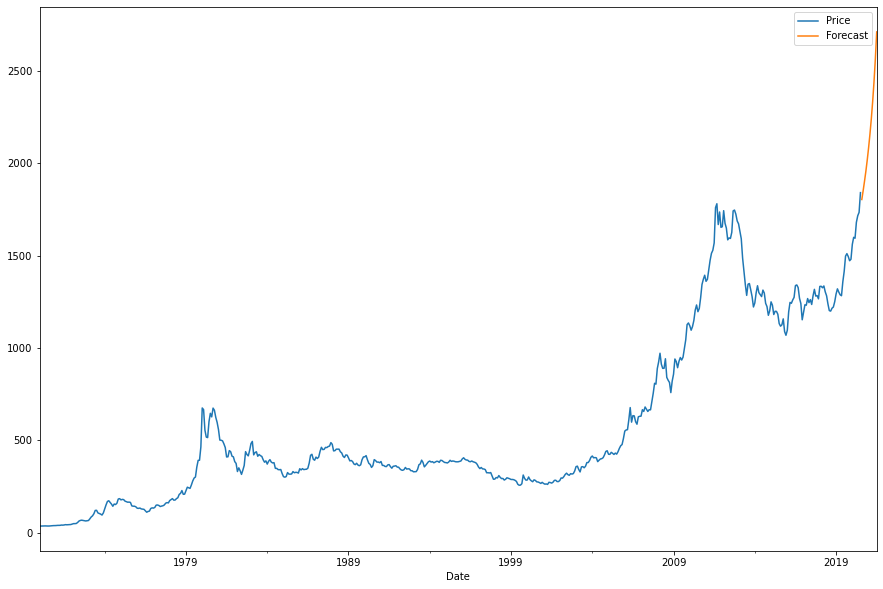

In [51]:
plt.figure(figsize=(15,10))
ax = data.plot()
forecast_df.plot(ax=ax,figsize=(15,10))

(605.0, 623.0)

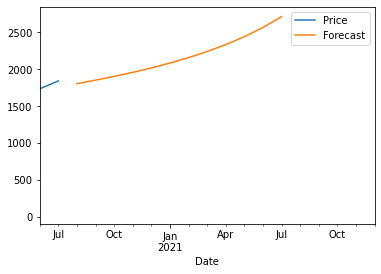

In [52]:
ax = data.plot()
forecast_df.plot(ax=ax)
plt.xlim('2020-06-01','2021-12-01')